# Sampling from a multivariate Gaussian using a GAN
In this example we'll try to learn a generator sampling from a simple $N$-dimensional multivariate Gaussian.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from vegans.GAN import WassersteinGAN
from vegans.utils.utils import plot_losses

In [2]:
z_dim = 32  # noise vector size
N = 20  # size of sampled vectors

## Prepare the "training" dataset
First, we define a $NxN$ covariance matrix, and plot it:

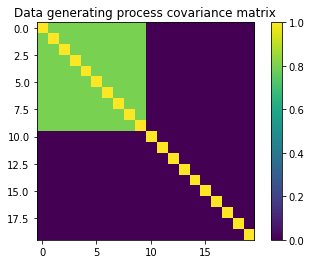

In [3]:
cov_mat = np.zeros(shape=(N, N))
cov_mat[0:10, 0:10] = 0.8
np.fill_diagonal(cov_mat, 1.0)

plt.imshow(cov_mat)
plt.title("Data generating process covariance matrix")
plt.colorbar();

Our goal will be to train a generator network in a GAN setting, which can sample from a distribution with a similar covariance matrix.

For reference, here's the sample covariance matrix, obtained when sampling from this distribution:

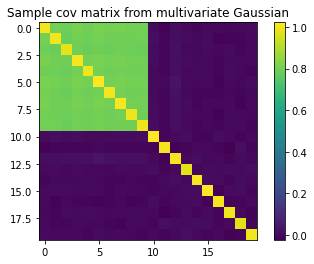

In [4]:
X_train = np.random.multivariate_normal(
    mean=np.array([0.0 for _ in range(N)]), cov=cov_mat, size=10000
)

# re-cover matrix
cov_mat_recovered = np.cov(X_train.T)

plt.imshow(cov_mat_recovered)
plt.title("Sample cov matrix from multivariate Gaussian")
plt.colorbar();

Let's now have a look at the distribution of our (flattened) training set:

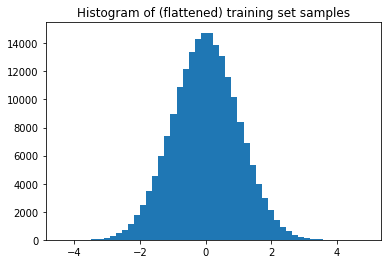

In [5]:
plt.hist(X_train.flatten(), bins=50)
plt.title("Histogram of (flattened) training set samples");

## Define our Generator and Critic Networks
Here we'll define some very simple nets.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.LeakyReLU(0.1),
        )
        self.output = nn.Linear(32, N)

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(N, 10), nn.LeakyReLU(0.1), nn.Linear(10, 1)
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x


critic = Critic()
generator = Generator()

We didn't train our generator yet, so it's just generating noise. What does the sample covariance matrix look like?

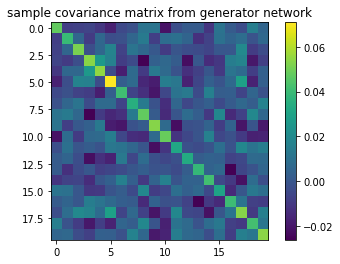

In [7]:
def plot_generator_cov(generator, n=10000):
    """Try the generator on a noise mini-batch and compute sample covariance matrix"""
    z = torch.from_numpy(np.random.randn(n, z_dim)).float()
    samples = generator(z)
    cov_mat_est = np.cov(samples.detach().numpy().T)
    plt.imshow(cov_mat_est)
    plt.title("sample covariance matrix from generator network")
    plt.colorbar()


plot_generator_cov(generator)

## Time for training!
We'll use [WGAN](https://arxiv.org/abs/1701.07875). Here we'll define our own optimizers for the generator and the critic, in order to use a slightly lower learning rate than the default one.

We'll train for 50 epochs.

We set `folder=None` so that no folder is created where all results would be stored. Otherwise we could give a path like `folder="TrainedModels/GAN"`. All results (summary, images, loss functions, tensorboard information, models) would be saved in that folder. You can control what should be saved in the `fit` method. This folder will never overwrite an existing folder. If the path already exists a new path of the form `folder=path_{TimeStamp}` is created.

In [8]:
optimizer = {"Generator": torch.optim.Adam, "Adversary": torch.optim.Adam}
optimizer_kwargs = {
    "Generator": {"lr": 0.0001, "betas": (0.5, 0.999)},
    "Adversary": {"lr": 0.0001, "betas": (0.5, 0.999)},
}

gan = WassersteinGAN(
    generator,
    critic,
    z_dim=z_dim,
    x_dim=N,
    optim=optimizer,
    optim_kwargs=optimizer_kwargs,
    device="cpu",
    folder=None,
)

The training happens in the next cell. You can interrupt it at any time without loosing the results.

In [9]:
gan.fit(X_train, epochs=25, print_every="1e", enable_tensorboard=False)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
Step: 313 / 7825 (Epoch: 1 / 25, Batch: 313 / 313)
------------------------------------------------------------
Generator: -0.009623228572309017
Adversary: -0.0010495688766241074
Adversary_fake: 0.009623228572309017
Adversary_real: -0.011722366325557232
RealFakeRatio: -1.2181323766708374


Time left: ~0.98 minutes (Steps remaining: 7512).
------------------------------------------------------------
EPOCH: 2
------------------------------------------------------------
Step: 626 / 7825 (Epoch: 2 / 25, Batch: 313 / 313)
------------------------------------------------------------
Generator: -0.009737596847116947
Adversary: -0.001524364110082388
Adversary_fake: 0.009737596847116947
Adversary_real: -0.012786325067281723
RealFakeRatio: -1.3130884170532227


Time left: ~0.82 minutes (Steps remaining: 7199).
---------------------------------------------------------

## Inspection of results
By calling `get_training_results()` on any GAN object, you can get a list of samples (generated out of a fixed noise vector), as well as the lists of losses of the generator and discriminator:

In [10]:
samples, losses = gan.get_training_results()

First, let's check what's the distribution of (flattened) samples during the last iteration:

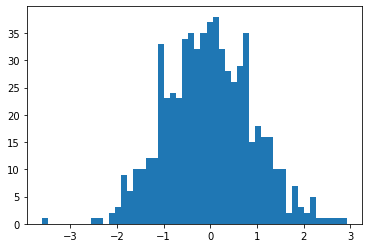

In [11]:
plt.hist(samples.flatten(), bins=50);

And now let's look at the losses of the generator and critic during training - we can just call `vegans.utils.plot_losses()`:

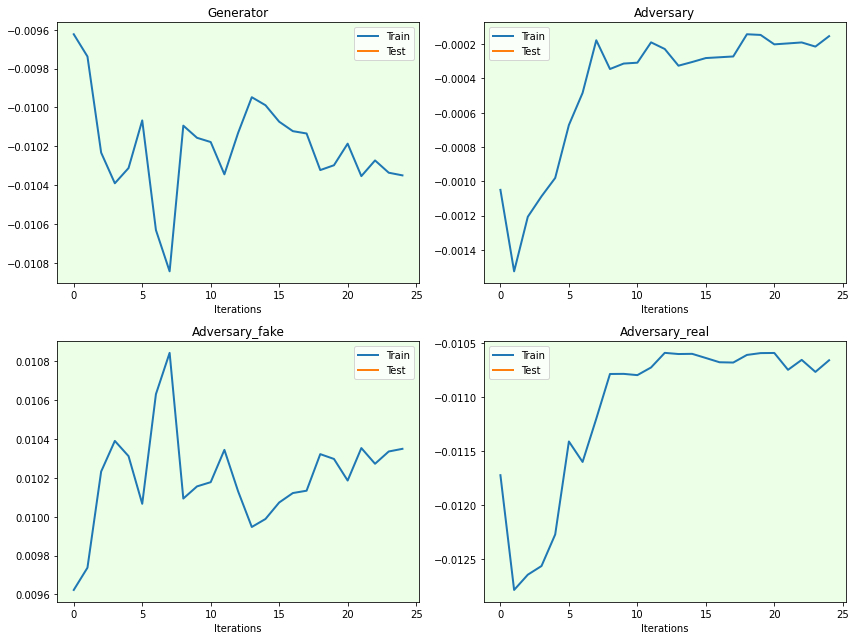

In [12]:
fig, axs = plot_losses(losses)

And the sample covariance matrix we obtain we drawing samples from our newly-trained generator:

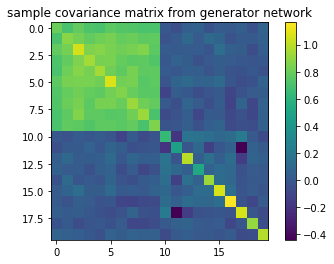

In [13]:
plot_generator_cov(generator)

It looks very similar to the original matrix.